In [1]:
import sys
from pathlib import Path
parent_dir = str(Path().resolve().parents[3])
sys.path.append(parent_dir)

from src.utils.plot import use_svg_display

import matplotlib.pyplot as plt

use_svg_display()

# Concept

## Problem Statement

```{prf:remark} Remark
:label: remark-kmeans-problem-statement

Although K-Means does not explicitly model the underlying distribution $\mathcal{D}$,
we can still apply the learning theory framework to K-Means.
```

**Given** a set $\mathcal{S}$ containing $N$ data points:

$$
\mathcal{S} = \left\{\mathbf{x}^{(1)}, \mathbf{x}^{(2)}, \dots, \mathbf{x}^{(N)}\right\} \subset \mathbb{R}^{D}
$$

where the vector $\mathbf{x}^{(n)}$ is the $n$-th sample with $D$ number of features, given by:

$$
\mathbf{x}^{(n)} \in \mathbb{R}^{D} = \begin{bmatrix} x_1^{(n)} & x_2^{(n)} & \cdots & x_D^{(n)} \end{bmatrix}^{\mathrm{T}} \quad \text{where } n = 0, 1, \ldots, N.
$$

We can further write $\mathcal{S}$ as a disjoint union [^disjoint_union] of $K$ sets, as follows:

$$
\begin{aligned}
\mathcal{S} &:= \left\{\mathbf{x}^{(1)}, \mathbf{x}^{(2)}, \dots, \mathbf{x}^{(N)}\right\} \subset \mathbb{R}^{D} = C_1 \sqcup C_2 \sqcup \cdots \sqcup C_K \\
\end{aligned}
$$

where $C_k$ is the set of data points that belong to cluster $k$:

$$
C_k = \left\{\mathbf{x}^{(n)} \in \mathbb{R}^{D} \middle\vert y^{(n)} = k\right\} .
$$ (eq:cluster-def)

The notation $y^{(n)} \in \{1, 2, \dots, K\}$ may seem strange at first glance, since we are not given the labels $y^{(n)}$
in an unsupervised problem. Indeed, this $y^{(n)}$ (**latent**) is generally not known to us,
but we can have a mental model that
for each data point, there is an underlying cluster label $y^{(n)}$ that it should belong to.

More concretely, we say that $y^{(n)} \in \{1, 2, \dots, K\}$ in equation {eq}`eq:cluster-def` refers to the cluster (ground truth) label of data point $\mathbf{x}^{(n)}$.

We further define $\mathcal{C}$ as the collection of these clusters[^collection_of_clusters],

$$
\mathcal{C} = \left\{C_1, C_2, \dots, C_K\right\}.
$$

To this end, we have decomposed the $N$ data points into $K$ clusters, where $K$
is a [*priori*](https://en.wikipedia.org/wiki/A_priori_and_a_posteriori), a pre-defined number.

---

The **K-Means** algorithm aims to group the data points into a set $\hat{\mathcal{C}}$ containing $K$ clusters:

$$
\hat{\mathcal{C}} = \left\{ \hat{C}_1, \hat{C}_2 \dots, \hat{C}_K \right\}
$$

where $ \hat{C}_k $ is the set of data points $ \mathbf{x}^{(n)} \in \mathcal{S}$ assigned by $ \mathcal{A}(\cdot) $ (explained shortly) to the $ k $-th cluster:

$$
\hat{C}_k = \left\{\mathbf{x}^{(n)} \in \mathbb{R}^{D} \middle\vert \mathcal{A}(n):= \hat{y}^{(n)} = k\right\}.
$$

Note that $\mathcal{A}(\cdot)$ is the assignment map that "predicts" and "classifies" each data point into their respective clusters.


To this end, the **goal** of such an **unsupervised problem** is to find the ***clusters***
$\hat{\mathcal{C}}$, the predicted clusters learnt by K-Means that best approximate the ground truth clusters $\mathcal{C}$.

In other words, we want to find the clusters $\hat{\mathcal{C}}$ that are the closest to the ground truth clusters $\mathcal{C}$, we will make precise the notion of *close* later.

It is also customary to denote $\hat{C}_k$ to be the set that contains the indices of the data points that belong to cluster $k$:

$$
\hat{C}_k = \left\{n \in \{1, 2, \dots, N\} \middle\vert \mathcal{A}(n):= \hat{y}^{(n)} = k\right\}.
$$

---

[K-Means clustering](https://en.wikipedia.org/wiki/K-means_clustering)'s goal is to find the clusters $\hat{\mathcal{C}}$ that are the closest to the ground truth clusters $\mathcal{C}$ (**hard clustering**).
In other words, we aim to partition $N$ data points $\mathcal{S}$ into $K$ clusters $\hat{\mathcal{C}}$.
The problem in itself seems manageable, since we can simply partition the data points into $K$ clusters
and minimize the intra-cluster distance (variances). However, it is computationally challenging to solve the problem ([NP-hard](https://en.wikipedia.org/wiki/NP-hardness)).

Consequently, there are many heuristics that are used to solve the problem. We will talk about one of the most popular heuristics,
the [Lloyd's algorithm](https://en.wikipedia.org/wiki/Lloyd%27s_algorithm) in this section.

In this algorithm, there exists $K$ centroids (centers)

$$
\boldsymbol{v}_1, \boldsymbol{v}_2, \dots, \boldsymbol{v}_K \in \mathbb{R}^{D}
$$

where $\boldsymbol{v}_k$ is defined to be the centroid of cluster $C_k$. Each centroid $\boldsymbol{v}_k$
is a vector that has the same dimension as the data points $\mathbf{x}^{(n)}$ and
is the **representative vector** of the cluster $C_k$.

By representative vector, we mean that
$\boldsymbol{v}_k$ is a vector that can "describe" the cluster $C_k$.
By construction, the centroids can be defined as any vector $\boldsymbol{v}_k$ that
has the same dimension as the data points $\mathbf{x}^{(n)}$. However, an
intuitive choice is to use the **mean** of the data points $\boldsymbol{\mu}_k$ in the cluster $\hat{C}_k$
as the representative vector $\boldsymbol{v}_k$.

Next, the formulation of the assignment rule $\mathcal{A}(\cdot)$ can be made clear by the intuition below:

> Since $\mathcal{A}(\cdot)$ is an assignment rule, an intuitive way is to find a representative vector $\boldsymbol{v}_k$ in each cluster $\hat{C}_k$, and assign every data point $\mathbf{x}^{(n)}$ that is closest to this representative. This is similar to the [nearest-neighbour search algorithm](https://en.wikipedia.org/wiki/Nearest_neighbor_search#:~:text=Nearest%20neighbor%20search%20(NNS)%2C,the%20larger%20the%20function%20values.).

Consequently, given the representative vectors $\left\{\boldsymbol{v}_k\right\}_{k=1}^K$,
we need an assignment function $\mathcal{A}(n) = \hat{y}^{(n)}$ that assigns each data point $\mathbf{x}^{(n)}$
to the cluster $\hat{C}_k$. An intuitive choice is to compare "closeness" of each $\mathbf{x}^{(n)}$
to the representative vectors $\left\{\boldsymbol{v}_k\right\}_{k=1}^K$ and assign
it to the cluster $\hat{C}_k$ that is closest to the representative vector $\boldsymbol{v}_k$.

We will make these intuition more precise later by proving it.

---

To this end, we have tidied up the flow of the Lloyd's algorithm (more details in subsequent sections), we
now finalize the problem statement by defining an appropriate [**loss**](https://en.wikipedia.org/wiki/Loss_function) and [**objective**](https://en.wikipedia.org/wiki/Mathematical_optimization) function. More formally, we want to
find the assignment $\mathcal{A}(\cdot)$ and the cluster center $\boldsymbol{v}_k$ such that the [**sum of squared distances**](https://en.wikipedia.org/wiki/Residual_sum_of_squares#:~:text=In%20statistics%2C%20the%20residual%20sum,such%20as%20a%20linear%20regression.) between each data point and its cluster center is minimized. This means partitioning the data points according to the [**Voronoi Diagram**](https://en.wikipedia.org/wiki/Voronoi_diagram).

To this end, we can define an *empirical* cost function that measures the quality of the
requirements listed earlier.

$$
\begin{aligned}
\widehat{\mathcal{J}}\left(\left\{\hat{y}^{(n)}\right\}_{n=1}^N,\left\{\boldsymbol{v}_{k}\right\}_{k=1}^k \middle \vert \mathcal{S}\right) &= \sum_{n=1}^{N} \left\|\mathbf{x}^{(n)} - \boldsymbol{v}_{\hat{y}^{(n)}} \right\|^2 \\
\end{aligned}
$$

Note that the clustering error $\widehat{\mathcal{J}}$ depends on **both** the **cluster assignments** $\hat{y}^{(n)}$, which
define the clusters $\hat{C}_k$, and the **cluster representatives** $\boldsymbol{v}_k$, for $k=1, \ldots, K$.
As mentioned earlier, finding the optimal cluster means $\left\{\boldsymbol{v}_k\right\}_{k=1}^K$
and cluster assignments $\left\{\hat{y}^{(n)}\right\}_{n=1}^N$ that minimize the clustering error $\widehat{\mathcal{J}}$
is a [NP-hard problem](https://cseweb.ucsd.edu/~avattani/papers/kmeans_hardness.pdf).
The difficulty stems from the fact that the clustering error $\mathcal{J}$ is a [non-convex](https://en.wikipedia.org/wiki/Convex_optimization)
function of the cluster means and assignments. In other words, there are many local minima of the clustering error $\mathcal{J}$, and finding the global minimum is hard.

While jointly optimizing the cluster means and assignments is hard[^jointly_optimizing],
separately optimizing either the cluster means for given assignments or vice-versa is easy.
In what follows, we present simple closed-form solutions for these sub-problems.
The $k$-means method simply combines these solutions in an alternating fashion {cite}`jung_2023`.

More concretely, we want to show:

- For fixed cluster assignments $\mathcal{A}(n) = \hat{y}^{(n)}$,
the clustering error $\widehat{\mathcal{J}}$ is minimized by setting the cluster representatives $\boldsymbol{v}_k$
equal to the cluster means, this means
the mean vector is the optimal
choice for the cluster center.

    $$
    \boldsymbol{\mu}_1, \boldsymbol{\mu}_2, \dots, \boldsymbol{\mu}_K \in \mathbb{R}^{D}
    $$

    where each $\boldsymbol{\mu}_k$ is the mean vector of the data points in cluster $C_k$.

- Furthermore, now when we obtain the cluster means $\boldsymbol{\mu}_k$ (now we fix $\boldsymbol{\mu}_k$,
  we can assign data points
$\mathbf{x}^{(n)}$ to the cluster $\hat{C}_k$ that is closest to the cluster mean $\boldsymbol{\mu}_k$.
This assignment action is called the **assignment function** $\mathcal{A}$, a function that
does the assignment of data points to clusters. We will show later that the clustering error $\widehat{\mathcal{J}}$ is minimized
when the assignment function is the **nearest neighbor assignment** function $\mathcal{A}^{*}(\cdot)$,


    $$
    \mathcal{A}^{*}(n) = \underset{k}{\operatorname{argmin}} \left\|\mathbf{x}^{(n)} - \boldsymbol{\mu}_k \right\|^2
    $$

    where it assigns data points $\mathbf{x}^{(n)}$ to the cluster $k$ whose center $\boldsymbol{\mu}_k$ is closest.

We see that instead of jointly optimizing the cluster means and assignments in one step, we alternate between
the two steps. We first fix the cluster assignments and optimize the cluster means, and then we fix the cluster means
and optimize the cluster assignments. Readings who are familiar with data structures and algorithms will notice
this looks like a [greedy algorithm](https://en.wikipedia.org/wiki/Greedy_algorithm), and those who have learnt the [expectation maximization](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm) algorithm will notice
that this is a special case of the expectation maximization algorithm.

In the following sections, we will phrase K-Means (Lloyd's algorithm) as an optimization problem, in which the goal is to find the optimal
cluster centers and cluster assignments that minimize the clustering error. We will also prove why this is the case.

## Intuition

Some intuition on choosing the cost function $\widehat{\mathcal{J}}$.

In supervised learning, we have our typical loss functions such as cross-entropy loss (classification),
and in regression, we have mean squared error. We also have
metrics like accuracy, precision, recall, etc to measure the performance of the model.

This means, given a hypothesis $\hat{y}:=h(\mathbf{x})$, how close is it to the true label $y$?
In unsupervised, we do not have such ground truth label $y$ to compare with, but the notion of
closeness is still there.

### Example

Let's first look at an example by randomly generating data points[^y] that can be
partitioned into 3 distinct clusters.

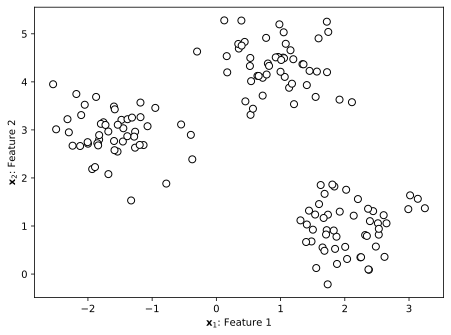

In [2]:
from sklearn.datasets import make_blobs

X, y = make_blobs(
    n_samples=150,
    n_features=2,
    centers=3,
    cluster_std=0.5,
    shuffle=True,
    random_state=0,
)

plt.scatter(X[:, 0], X[:, 1], c="white", marker="o", edgecolor="black", s=50)
plt.xlabel("$\mathbf{x}_1$: Feature 1")
plt.ylabel("$\mathbf{x}_2$: Feature 2")

plt.grid(False)
plt.tight_layout()
plt.show()

Visually, we can literally just circle out the 3 clusters. The luxury of such simplicity
is because we are working with 2 features, i.e. $\mathbf{x} \in \mathbb{R}^{2}$.
In real world, we are working with
$D$ features in $\mathbb{R}^{D}$, where $D$ can be very large. Furthermore, even with
such a simple dataset, how do we tell the machine to find the 3 clusters?

### The Notion of Similarity and Closeness

To define such a metric for unsupervised learning, we can fall back on our intuition.
The purpose of clustering is to group similar data points together. So we seek to find
a metric that measures the similarity between data points in a dataset.

A very simple idea is to use
[**intra-cluster variance**](https://stats.stackexchange.com/questions/120509/inter-cluster-variance). For example, within a cluster, the data points are close to each other if
the variance is small.

Consequently, to make our intuition precise, we need to define a metric rule and an assignment $\mathcal{A}(\cdot)$ to assign data points to clusters. We also
need to define the notion of closeness and similarity between data points.

Lastly, such algorithms require an initial guess of the cluster centers, so that
eventually the algorithm can converge to the optimal cluster centers, since we have no way of knowing
the optimal cluster centers beforehand, especially in high dimensional space.

More formally, the optimization problem requires us to minimize the sum of squared distances between each data point and its cluster center.
This is equivalent to minimizing the variance within each cluster.

Let's look at some definitions first that will gradually lead us to the formulation of the objective function.

## Partition and Voronoi Regions

K-Means can be formulated via the lens of [**Voronoi regions**](https://en.wikipedia.org/wiki/Voronoi_diagram)
where we define $C_k \in \mathcal{C}$ as the **partition** of the data set $\mathcal{S}$, where each subset is a cluster.
We say that $C_k$ is a representative of the cluster $k$ and induces a **Voronoi partition** of $\mathbb{R}^D$.
More formally, we define the Voronoi partition as follows:

```{prf:definition} K-Means Voronoi Partition
:label: def:kmeans-voronoi-partition

Let $\mathcal{C} = \{C_1, C_2, \ldots, C_K\}$ be a partition of $\mathcal{S}$, where $C_k \in C$ is a subset of $\mathcal{S}$.
Then $\mathcal{C}$ induces a **Voronoi partition** ({prf:ref}`def-voronoi-region`) of $\mathbb{R}^D$, which decomposes $\mathbb{R}^D$ into $K$ convex cells,
each corresponding to some $C_k \in \mathcal{C}$ and containing the region of space whose nearest representative is $C_k$.

More concretely, the Voronoi region $C_k$, contains all points $\mathbf{x} \in \mathbb{R}^D$ such that

$$
\begin{aligned}
\left\|\mathbf{x} - \boldsymbol{v}_k \right\|^2 \leq \left\|\mathbf{x} - \boldsymbol{v}_j \right\|^2 \text{ for all } j \neq k
\end{aligned}
$$

which means that the distance between $\mathbf{x}$ and $\boldsymbol{v}_k$ is less than or equal to the distance between $\mathbf{x}$ and any other cluster center $\boldsymbol{v}_j$.

Also,

$$
\mathcal{S} = \bigsqcup_{k=1}^K C_k
$$
```

For a visual representation, see {cite:ps}`pml1Book`'s [figure](https://github.com/probml/pyprobml/blob/master/notebooks/book1/21/kmeans_voronoi.ipynb).

## Assignment

```{prf:definition} Assignment
:label: def:assignment

An assignment $\mathcal{A}(\cdot)$ is a surjective map,

$$
\begin{aligned}
\mathcal{A} : \mathbb{Z}^{+} &\to \mathbb{Z}^{+} \\
\{1, 2, \dots, N\} &\to \{1, 2, \dots, K\} .
\end{aligned}
$$

In this case, $\mathcal{A}(n) = k$ means that data point $\mathbf{x}^{(n)}$ is assigned to cluster $k$.

One should see that the assignment function $\mathcal{A}(\cdot)$ gives rise to the prediction $\hat{y}^{(n)}$
for each data point $\mathbf{x}^{(n)}$.

$$
\hat{y}^{(n)} = \mathcal{A}(n) \quad \text{for } n = 1, 2, \dots, N.
$$ (eq:assignment-prediction)
```

```{prf:example} Assignment
:label: example:assignment

For example, if we have 4 data points $\mathbf{x}^{(1)}$, $\mathbf{x}^{(2)}$, $\mathbf{x}^{(3)}$, and $\mathbf{x}^{(4)}$,
and we want to partition them into 3 clusters $\hat{C}_1$, $\hat{C}_2$, and $\hat{C}_3$, we can define an assignment as follows:

- Assign $\mathbf{x}^{(1)}$ to $\hat{C}_1$, $\hat{C}_1 = \left\{\mathbf{x}^{(1)}\right\}$.
- Assign $\mathbf{x}^{(3)}$ to $\hat{C}_2$, $\hat{C}_2 = \left\{\mathbf{x}^{(3)}\right\}$.
- Assign $\mathbf{x}^{(2)}$ and $\mathbf{x}^{(4)}$ to $\hat{C}_3$, $\hat{C}_3 = \left\{\mathbf{x}^{(2)}, \mathbf{x}^{(4)}\right\}$.

We can make this more precise by defining an assignment function $\mathcal{A}$ as follows:

$$
\begin{aligned}
\mathcal{A} : \mathbb{Z}^{+} &\to \mathbb{Z}^{+} \\
\{1, 2, 3, 4\} &\to \{1, 2, 3\}
\end{aligned}
$$

where

- $\mathcal{A}(1) = 1$,
- $\mathcal{A}(2) = 3$,
- $\mathcal{A}(3) = 2$, and
- $\mathcal{A}(4) = 3$.
```

We have seen earlier that the assignment function of the K-Means algorithm follows the nearest-neighbour rule, but
we did not explicitly define it here just yet. We will derive that the optimal assignment
$\mathcal{A}^{*}(\cdot)$ is the one that minimizes the cost function:

$$
\mathcal{A}^{*}(n) = \underset{k}{\operatorname{argmin}} \left\|\mathbf{x}^{(n)} - \boldsymbol{\mu}_k \right\|^2
$$ (eq:assignment-optimal-1)

## Centroids (Representatives)

```{prf:definition} Centroids
:label: def:centroids

The centroids $\boldsymbol{v}_1, \boldsymbol{v}_2, \ldots, \boldsymbol{v}_K$ of a partition $\hat{\mathcal{C}}$ are the representatives of each cluster $C_k \in \hat{\mathcal{C}}$:

$$
\boldsymbol{v}_k \text{ represents cluster } C_k \text{ for } k = 1, 2, \ldots, K.
$$
```

## Cost Function

We make precise the notion of closeness and similarity between data points by defining a cost function
utilizing the [**euclidean distance**](https://en.wikipedia.org/wiki/Euclidean_distance). In practice, we can use other distance metrics such as [**manhattan distance**](https://simple.wikipedia.org/wiki/Manhattan_distance)
that suits one's needs.

```{prf:definition} K-Means Cost Function
:label: def:kmeans-cost

For any assignment $\mathcal{A}(\cdot)$ that maps the set $\{1, 2, \ldots, N\}$ to $\{1, 2, \ldots, K\}$ and
any centroids $\boldsymbol{v}_1, \boldsymbol{v}_2, \dots, \boldsymbol{v}_K \in \mathbb{R}^{D}$,
we construct the cost function as follows:

$$
\begin{aligned}
\widehat{\mathcal{J}}_{\mathcal{S}}(\mathcal{A}, \boldsymbol{v}_1, \boldsymbol{v}_2, \ldots, \boldsymbol{v}_K) &:= \widehat{\mathcal{J}}\left(\left\{\hat{y}^{(n)}\right\}_{n=1}^N,\left\{\boldsymbol{v}_{k}\right\}_{k=1}^k \middle \vert \mathcal{S}\right) \\
&\overset{\text{(a)}}{=} \sum_{n=1}^{N} \left\|\mathbf{x}^{(n)} - \boldsymbol{v}_{\mathcal{A}(n)} \right\|^2 \\
&\overset{\text{(b)}}{=} \sum_{n=1}^{N} \sum_{\mathcal{A}(n) = k} \left\|\mathbf{x}^{(n)} - \boldsymbol{v}_k \right\|^2 \\
&\overset{\text{(c)}}{=} \sum_{n=1}^{N} \sum_{k=1}^{K} r^{(n)}_k \left\|\mathbf{x}^{(n)} - \boldsymbol{v}_k \right\|^2 \\
&\overset{\text{(d)}}{=} \sum_{n=1}^{N} \sum_{k=1}^{K} \mathbb{I}\left\{\mathcal{A}(n) = k\right\} \left\|\mathbf{x}^{(n)} - \boldsymbol{v}_k \right\|^2 \\
&\overset{\text{(e)}}{=} \sum_{k=1}^K \sum_{\mathbf{x}^{(n)} \in \hat{C}_k} \left\|\mathbf{x}^{(n)} - \boldsymbol{v}_k \right\|^2 \\
\end{aligned}
$$ (eq:kmeans-cost-1)

where

- $\mathcal{A}(n) = k$ means that data point $\mathbf{x}^{(n)}$ is assigned to cluster $k$.
- $r^{(n)}_k$ is an indicator function that is equal to 1 if $\mathcal{A}(n) = k$ and 0 otherwise.

    $$
    \begin{aligned}
    r^{(n)}_k &= \begin{cases} 1 & \text{if } \mathcal{A}(n) = k \\ 0 & \text{otherwise} \end{cases}
    \end{aligned}
    $$
- $\hat{C}_k$ is the set of data points that are assigned to cluster $k$.
- $\left\|\cdot\right\|$ is the euclidean norm.

    $$
    \begin{aligned}
    \left\|\mathbf{x} - \boldsymbol{v}\right\|^2 &= \left(\mathbf{x} - \boldsymbol{v}\right)^{\top} \left(\mathbf{x} - \boldsymbol{v}\right) \\
    \end{aligned}
    $$
- All 5 forms are equivalent[^equivalent-k-means-cost-function].

It is worth a reminder that we have not formally defined what the assignment $\mathcal{A}(\cdot)$ is, as well
as the representative vectors (centroids) $\boldsymbol{v}_1, \boldsymbol{v}_2, \dots, \boldsymbol{v}_K$. We will show later that
$\boldsymbol{v}_k$ is the mean of the data points in cluster $k$ and that $\mathcal{A}(n)=\underset{k}{\operatorname{argmin}} \left\|\mathbf{x}^{(n)} - \boldsymbol{\mu}_k \right\|^2$ is the assignment
that minimizes the cost function $\widehat{\mathcal{J}}_{\mathcal{S}}$.
```

```{prf:remark} Cost Function is a Function of Assignment and Centroids
:label: remark:cost-function-is-a-function-of-assignment-and-centroids

The cost function is a function **both** the assignment $\mathcal{A}(\cdot)$ and the cluster centers $\boldsymbol{v}_1, \boldsymbol{v}_2, \dots, \boldsymbol{v}_K$,
which adds up the squared euclidean distance between each data point and its assigned cluster center. The
total cost is what we are minimizing. Note that the problem is equivalent to minimizing each
cluster's cost individually.

We also call the loss sum of squared error (SSE) , which is just the intra-cluster variance, a measure of how spread out the data points are within a cluster.
```

## Objective Function

Finally, we define the objective function as the cost function $\widehat{\mathcal{J}}_{\mathcal{S}}$ that we are minimizing.

```{prf:definition} K-Means Objective Function
:label: def:kmeans-objective

The **objective** function is to **minimize** the above expression in equation {eq}`eq:kmeans-cost-1`:

$$
\begin{alignat}{3}
\underset{\mathcal{A}, \boldsymbol{v}_k}{\operatorname{argmin}} &\quad& \widehat{\mathcal{J}}_{\mathcal{S}}(\mathcal{A}, \boldsymbol{v}_1, \boldsymbol{v}_2, \ldots, \boldsymbol{v}_K) &= \sum_{n=1}^{N} \sum_{\mathcal{A}(n) = k} \left\|\mathbf{x}^{(n)} - \boldsymbol{v}_k \right\|^2  \\
\text{subject to} &\quad& \hat{C}_1 \sqcup \hat{C}_2 \sqcup \cdots \sqcup \hat{C}_K &= \mathcal{S} \\
&\quad& \boldsymbol{v}_1, \boldsymbol{v}_2, \ldots, \boldsymbol{v}_K &\in \mathbb{R}^D \\
\end{alignat}
$$ (eq:k-means-objective-function-1)

This just means, for all possible assignments $\mathcal{A}(\cdot)$ and cluster centers $\boldsymbol{v}_1, \boldsymbol{v}_2, \ldots, \boldsymbol{v}_K$, we want to find the assignment $\mathcal{A}(\cdot)$ and cluster centers $\boldsymbol{v}_1, \boldsymbol{v}_2, \ldots, \boldsymbol{v}_K$ that minimize the cost function $\widehat{\mathcal{J}}_{\mathcal{S}}$.

In other words, of all possible sets (there's a lot, as we should see later) $\hat{\mathcal{C}} = \left\{\hat{C}_1, \hat{C}_2, \ldots, \hat{C}_K\right\}$, we want to find the set $\hat{\mathcal{C}}$ that minimizes the cost function $\widehat{\mathcal{J}}_{\mathcal{S}}$.
```

```{prf:theorem} Minimizing Individual Cluster's Cost is Equivalent to Minimizing the Objective Function
:label: thm:minimizing-individual-clusters-cost-is-equivalent-to-minimizing-the-objective-function

The objective function is equivalent to minimizing each cluster's cost individually.
```

Recall we mentioned that optimizing the objective function $\widehat{\mathcal{J}}_{\mathcal{S}}$ means
we are finding the optimal assignment $\mathcal{A}^*(\cdot)$ and the optimal cluster centers $\boldsymbol{v}_1^*, \boldsymbol{v}_2^*, \ldots, \boldsymbol{v}_K^*$
at the same time. This is challenging as $\widehat{\mathcal{J}}_{\mathcal{S}}$ is a non-convex function of $\mathcal{A}(\cdot)$ and $\boldsymbol{v}_1, \boldsymbol{v}_2, \ldots, \boldsymbol{v}_K$.
We will now fall back on heuristics to find the local optimum. In what follows,
we will list the *necessary* conditions to minimize the objective function $\widehat{\mathcal{J}}_{\mathcal{S}}$.

## The Necessary Conditions to Minimize the Objective Function

With all the definitions in place, we can now formally state the necessary conditions to minimize the objective function.

Note a necessary condition only guarantees that if a solution is optimal, then the conditions must be satisfied.
However, if a solution does satisfy the conditions, it does not necessarily mean that it is optimal. In short,
we may land ourselves with a **local** minimum that is not **globally** optimal.

### Condition 1: The Optimal Assignment

```{prf:criterion} K-Means Optimal Assignment
:label: criterion:kmeans-optimal-assignment

Fix the cluster centers $\boldsymbol{v}_1, \boldsymbol{v}_2, \ldots, \boldsymbol{v}_K$, we seek
the optimal assignment $\mathcal{A}^*(\cdot)$ that minimizes the cost function $\widehat{\mathcal{J}}_{\mathcal{S}}(\cdot)$.

We claim that the optimal assignment $\mathcal{A}^*(\cdot)$ follows the *nearest neighbor* rule, which means that,

$$
\begin{aligned}
\mathcal{A}^*(n) = \underset{k \in \{1, 2, \ldots, K\}}{\operatorname{argmin}} \left\|\mathbf{x}^{(n)} - \boldsymbol{v}_k \right\|^2 .
\end{aligned}
$$ (eq:k-means-criterion-1.1)

Then the assignment $\mathcal{A}^*$ is the optimal assignment that minimizes the cost function $\widehat{\mathcal{J}}_{\mathcal{S}}$.

This is quite intuitive as we are merely assigning each data point $\mathbf{x}^{(n)}$ to cluster $k$
whose center $\boldsymbol{v}_k$ is closest to $\mathbf{x}^{(n)}$.

We rephrase the claim by saying that for any assignment $\mathcal{A}$, we have

$$
\begin{aligned}
\widehat{\mathcal{J}}_{\mathcal{S}}(\mathcal{A}, \boldsymbol{v}_1, \boldsymbol{v}_2, \ldots, \boldsymbol{v}_K) &\geq \widehat{\mathcal{J}}_{\mathcal{S}}(\mathcal{A}^*, \boldsymbol{v}_1, \boldsymbol{v}_2, \ldots, \boldsymbol{v}_K) \\
\end{aligned}
$$ (eq:k-means-criterion-1.2)

Let's prove this claim.
```

```{prf:proof}
In equation {eq}`eq:k-means-criterion-1.2`, we have that $\boldsymbol{v}_1, \boldsymbol{v}_2, \ldots, \boldsymbol{v}_K$ are fixed.

$$
\begin{aligned}
\widehat{\mathcal{J}}_{\mathcal{S}}(\mathcal{A}, \boldsymbol{v}_1, \boldsymbol{v}_2, \ldots, \boldsymbol{v}_K) &= \sum_{n=1}^{N} \sum_{\mathcal{A}(n) = k} \left\|\mathbf{x}^{(n)} - \boldsymbol{v}_k \right\|^2 \\
&\geq \sum_{n=1}^{N} \sum_{\mathcal{A}^*(n) = k} \left\|\mathbf{x}^{(n)} - \boldsymbol{v}_k \right\|^2 \\
&= \widehat{\mathcal{J}}_{\mathcal{S}}(\mathcal{A}^*, \boldsymbol{v}_1, \boldsymbol{v}_2, \ldots, \boldsymbol{v}_K)
\end{aligned}
$$

This is just a proof by definition of $\mathcal{A}^*$ since

$$
\begin{aligned}
\left\|\mathbf{x}^{(n)} - \boldsymbol{v}_{\mathcal{A}(n)} \right\|^2 \geq \left\|\mathbf{x}^{(n)} - \boldsymbol{v}_{\mathcal{A}^*(n)} \right\|^2 .
\end{aligned}
$$

If you look at it intuitively, it just means there does not exist any other arrangement/assignment $\mathcal{A}$
that can reduce the cost function $\widehat{\mathcal{J}}_{\mathcal{S}}$ better than the optimal assignment $\mathcal{A}^*$ (nearest neighbor rule).
```

### Condition 2: The Optimal Cluster Centers (Centroids)

```{prf:criterion} K-Means Optimal Cluster Centers
:label: criterion:kmeans-optimal-cluster-centers

Fix the assignment $\mathcal{A}^*(\cdot)$, we seek the optimal cluster centers $\boldsymbol{v}_1^*, \boldsymbol{v}_2^*, \ldots, \boldsymbol{v}_K^*$ that minimize the cost function $\widehat{\mathcal{J}}_{\mathcal{S}}$.

We claim that the optimal cluster centers is the mean of the data points assigned to each cluster.

$$
\begin{aligned}
\boldsymbol{v}_k^* = \frac{1}{\left|\hat{C}_k^*\right|} \sum_{\mathbf{x}^{(n)} \in \hat{C}_k^*} \mathbf{x}^{(n)}
\end{aligned}
$$ (eq:k-means-criterion-2.1)

where $\left|\hat{C}_k^*\right|$ is the number of data points assigned to cluster $k$. We can denote it
as $N_k$ for convenience.

We can also rephrease this claim by saying that for any cluster centers $\boldsymbol{v}_1, \boldsymbol{v}_2, \ldots, \boldsymbol{v}_K$, fixing the assignment $\mathcal{A}^*$, we have

$$
\begin{aligned}
\widehat{\mathcal{J}}_{\mathcal{S}}(\mathcal{A}^*, \boldsymbol{v}_1, \boldsymbol{v}_2, \ldots, \boldsymbol{v}_K) &\geq \widehat{\mathcal{J}}_{\mathcal{S}}(\mathcal{A}^*, \boldsymbol{v}_1^*, \boldsymbol{v}_2^*, \ldots, \boldsymbol{v}_K^*) \\
\end{aligned}
$$ (eq:k-means-criterion-2.2)
```

```{prf:proof}
This proof in short just says that the mean minimizes the sum of squared distances.

Since we established ({prf:ref}`thm:minimizing-individual-clusters-cost-is-equivalent-to-minimizing-the-objective-function`)
that minimizing each individual cluster $\hat{C}_k$ is equivalent to minimizing the cost function $\widehat{\mathcal{J}}_{\mathcal{S}}$,
we can now fix any cluster $\hat{C}_k$ (i.e. also fixing the assignment $\mathcal{A}^*$) and seek the optimal cluster center $\boldsymbol{v}_k^*$ that minimizes the cost function $\widehat{\mathcal{J}}_{\hat{C}_k}$.

Note after fixing the assignment $\mathcal{A}^*(\cdot)$, $\widehat{\mathcal{J}}_{\hat{C}_k}$ is now just a
function of $\boldsymbol{v}_k$ and is the cost for that cluster.

$$
\begin{aligned}
\widehat{\mathcal{J}}_{\hat{C}_k}(\boldsymbol{v}_k) = \sum_{\mathbf{x}^{(n)} \in \hat{C}_k} \left\|\mathbf{x}^{(n)} - \boldsymbol{v}_k \right\|^2
\end{aligned}
$$

We can now take the derivative of $\widehat{\mathcal{J}}_{\hat{C}_k}$ with respect to $\boldsymbol{v}_k$ and set it to zero to find the optimal cluster center $\boldsymbol{v}_k^*$.

$$
\begin{aligned}
\frac{\partial}{\partial \boldsymbol{v}_k} \widehat{\mathcal{J}}_{\hat{C}_k}(\boldsymbol{v}_k) &= \frac{\partial}{\partial \boldsymbol{v}_k} \sum_{\mathbf{x}^{(n)} \in \hat{C}_k} \left\|\mathbf{x}^{(n)} - \boldsymbol{v}_k \right\|^2 \\
&= 2 \sum_{\mathbf{x}^{(n)} \in \hat{C}_k} \left(\mathbf{x}^{(n)} - \boldsymbol{v}_k \right) \\
&= 2 \left( \sum_{\mathbf{x}^{(n)} \in \hat{C}_k} \mathbf{x}^{(n)} - \sum_{\mathbf{x}^{(n)} \in \hat{C}_k} \boldsymbol{v}_k \right) \\
&= 2 \left( \sum_{\mathbf{x}^{(n)} \in \hat{C}_k} \mathbf{x}^{(n)} - N_k \boldsymbol{v}_k \right) \\
\end{aligned}
$$ (eq:derivative-of-k-means-cost-function)

where $N_k$ is the number of data points assigned to cluster $k$.

Now to minimize equation {eq}`eq:derivative-of-k-means-cost-function`, we set it to zero and solve for $\boldsymbol{v}_k$.

$$
\begin{align*}
&\quad
\frac{\partial}{\partial \boldsymbol{v}_k} \widehat{\mathcal{J}}_{\hat{C}_k}(\boldsymbol{v}_k) = 0 \\
\iff &\quad 2 \left( \sum_{\mathbf{x}^{(n)} \in \hat{C}_k} \mathbf{x}^{(n)} - N_k \boldsymbol{v}_k \right) = 0 \\
\iff &\quad \sum_{\mathbf{x}^{(n)} \in \hat{C}_k} \mathbf{x}^{(n)} - N_k \boldsymbol{v}_k = 0 \\
\iff &\quad \sum_{\mathbf{x}^{(n)} \in \hat{C}_k} \mathbf{x}^{(n)} = N_k \boldsymbol{v}_k \\
\iff &\quad \boldsymbol{v}_k = \frac{1}{N_k} \sum_{\mathbf{x}^{(n)} \in \hat{C}_k} \mathbf{x}^{(n)} \\
\end{align*}
$$

recovering {prf:ref}`criterion:kmeans-optimal-cluster-centers`.

There are other variants of [proof](https://math.stackexchange.com/questions/967138/formal-proof-that-mean-minimize-squared-error-function).
```

```{prf:remark} Notation
:label: prf:remark:kmeans-optimal-cluster-centers-notation

We will now denote $\boldsymbol{v}_k^*$ as $\boldsymbol{\mu}_k$ in the following sections.
```

### Objective Function Re-defined

We can now re-define the objective function in equation {eq}`eq:k-means-objective-function-1` in terms of the optimal cluster centers and assignments.

$$
\begin{alignat}{4}
\underset{\mathcal{A}, \boldsymbol{\mu}_k}{\operatorname{argmin}} &\quad& \widehat{\mathcal{J}}_{\mathcal{S}}(\mathcal{A}, \boldsymbol{\mu}_1, \boldsymbol{\mu}_2, \ldots, \boldsymbol{\mu}_K) &= \sum_{n=1}^{N} \sum_{\mathcal{A}(n) = k} \left\|\mathbf{x}^{(n)} - \boldsymbol{\mu}_k \right\|^2  \\
\text{subject to} &\quad& \hat{C}_1 \cup \hat{C}_2 \cup \cdots \cup \hat{C}_K &= \mathcal{S} \\
&\quad& \boldsymbol{\mu}_1, \boldsymbol{\mu}_2, \ldots, \boldsymbol{\mu}_K &\in \mathbb{R}^D \\
&\quad& \hat{y}^{(n)} := \mathcal{A}(n) &= \underset{k}{\operatorname{argmin}} \left\|\mathbf{x}^{(n)} - \boldsymbol{\mu}_k \right\|^2 \\
\end{alignat}
$$ (eq:k-means-objective-function-2)

```{prf:remark} Cost Function is a function of assignments and cluster centers
:label: remark:kmeans-cost-function-is-a-function-of-assignments-and-cluster-centers

Reminder!

The cost function in equation {eq}`eq:k-means-objective-function-2` is a function of **both** the cluster assignments and cluster centers.
And therefore we are minimizing the cost function with respect to the cluster assignments and cluster centers. However,
jointly optimizing both the cluster assignments and cluster centers is computationally challenging, and therefore
we split to two steps, first optimizing the cluster assignments and then optimizing the cluster centers in a greedy manner.
```

## Algorithm

We are now ready to define the full Lloyd's algorithm for K-Means.

```{prf:algorithm} Lloyd's Algorithm (K-Means)
:label: lloyd-kmeans-algorithm

Given a set of data points (samples)

$$
\mathcal{S} = \left\{\mathbf{x}^{(1)}, \mathbf{x}^{(2)}, \dots, \mathbf{x}^{(N)}\right\}
$$

the K-Means algorithm aims to group the data points into $K$ clusters

$$
\hat{\mathcal{C}} = \left\{ \hat{C}_1, \hat{C}_2, \dots, \hat{C}_K \right\}
$$

such that the sum of squared distances
between each data point and its cluster center is minimized.

In code, $\hat{\mathcal{C}}$ can be treated as a dictionary/hash map,
where the **key** is the cluster number and the **value** is the set of data points assigned to that cluster.


1. **Initialization Step**: Initialize $K$ cluster centers $\boldsymbol{\mu}_1^{[0]}, \boldsymbol{\mu}_2^{[0]}, \dots, \boldsymbol{\mu}_K^{[0]}$ randomly (best to be far apart)
where the superscript $[0]$ denotes the iteration number $t=0$.
    - In the very first iteration, there are no data points in any cluster $\hat{C}_k^{[0]} = \emptyset$. Therefore, the cluster centers are just randomly chosen for simplicity.
    - By random, we mean that the cluster centers are randomly chosen from the data points $\mathcal{S} = \left\{\mathbf{x}^{(1)}, \mathbf{x}^{(2)}, \dots, \mathbf{x}^{(N)}\right\}$
    and not randomly chosen from the feature space $\mathbb{R}^D$.
    - Subsequent iterations will have data points in the clusters $\hat{C}_k^{[t]} \neq \emptyset$ and thus
    $\boldsymbol{\mu}_k^{[t]}$ will be the mean of the data points in cluster $k$.
    - Each $\boldsymbol{\mu}_k^{[0]} = \begin{bmatrix} \mu_{1k}^{[0]} & \mu_{2k}^{[0]} & \cdots & \mu_{Dk}^{[0]} \end{bmatrix}^{\mathrm{T}}$ is a $D$-dimensional vector, where $D$ is the number of features, and represents the
    mean vector of all the data points in cluster $k$.
    - Note that $\mu_{dk}^{[0]}$ is the mean value of the $d$-th feature in cluster $k$.
    - We denote $\boldsymbol{\mu} = \begin{bmatrix} \boldsymbol{\mu}_1 & \boldsymbol{\mu}_2 & \cdots & \boldsymbol{\mu}_K \end{bmatrix}_{K \times D}^{\mathrm{T}}$ to be the collection of all $\boldsymbol{\mu}_1, \boldsymbol{\mu}_2, \dots, \boldsymbol{\mu}_K$.


2. **Assignment Step (E)**: For $t=0, 1, 2, \dots$, assign each data point $\mathbf{x}^{(n)}$ to the closest cluster center $\boldsymbol{\mu}_k^{[t]}$,

    $$
    \begin{aligned}
    \hat{y}^{(n)[t]} := \mathcal{A}^{*(n)[t]} &= \underset{k \in \{1, 2, \ldots, K\}}{\operatorname{argmin}} \left\| \mathbf{x}^{(n)} - \boldsymbol{\mu}_k^{[t]} \right\|^2 \\
    \end{aligned}
    $$ (eq:kmeans-classify)

    In other words, $\hat{y}^{(n)[t]}$ is the output of the optimal assignment rule at the $t$-th iteration
    and is the index of the cluster center $\boldsymbol{\mu}_k^{[t]}$ that is closest to $\mathbf{x}^{(n)}$.

    For instance, if $K = 3$, and for the first sample point $n=1$,
    assume the closest cluster center is $\boldsymbol{\mu}_2^{[t]}$, then the assignment $\mathcal{A}^{*}$ will
    assign this point to cluster $k=2$, $\hat{y}^{(1)} = 2$. Note that $\hat{y}^{(n)}$ is a scalar and has the same superscript as $\mathbf{x}^{(n)}$, indicating they belong to the same sample.

    For notational convenience, we can also denote $\hat{C}_k^{[t]}$ as the set of data points that are assigned to cluster $k$:

    $$
    \begin{aligned}
    \hat{C}_k^{[t]} &= \left\{ \mathbf{x}^{(n)} \mid \hat{y}^{(n)} = k \right\}
    \end{aligned}
    $$

    Mathematically, this means partitioning the data points using [Voronoi Diagram](https://en.wikipedia.org/wiki/Voronoi_diagram),
    as mentioned in the previous section {prf:ref}`def:kmeans-voronoi-partition`.

3. **Update Step (M)**: Update the cluster centers for the next iteration.

    $$
    \begin{aligned}
    \boldsymbol{\mu}_k^{[t+1]} &= \frac{1}{|\hat{C}_k^{[t]}|} \sum_{\mathbf{x}^{(n)} \in \hat{C}_k^{[t]}} \mathbf{x}^{(n)} \\
    \end{aligned}
    $$ (eq:kmeans-recenter)

    Notice that the cluster center $\boldsymbol{\mu}_k^{[t+1]}$ is the mean of all data points that are assigned to cluster $k$.

4. Repeat steps 2 and 3 until the centroids stop changing.

    $$
    \begin{aligned}
    \boldsymbol{\mu}_k^{[t+1]} = \boldsymbol{\mu}_k^{[t]}
    \end{aligned}
    $$ (eq:kmeans-convergence)

    In other words,

    $$
    \begin{aligned}
    \widehat{\mathcal{J}}_{\mathcal{S}}^{[t+1]}\left(\mathcal{A}^{*[t+1]}, \boldsymbol{\mu}^{[t+1]} \right) = \widehat{\mathcal{J}}_{\mathcal{S}}^{[t]}\left(\mathcal{A}^{*[t]}, \boldsymbol{\mu}^{[t]} \right)
    \end{aligned}
    $$

    This is the convergence condition.
```

```{prf:remark} K-Means is a Greedy Algorithm
:label: remark-kmeans-greedy

It is important to recognize that the K-Means (Lloyd's) Algorithm optimizes two objectives in an alternating fashion.
It alternatively changes both the assignment step $\mathcal{A}^{*}(\cdot)$ and the update step $\boldsymbol{\mu}_k^{[t+1]}$
to greedily minimize the cost function $\widehat{\mathcal{J}}(\mathcal{A}, \boldsymbol{\mu})$.
```

## Convergence

In this section, we will prove that the K-Means Algorithm converges to a local minimum of the cost function $\widehat{\mathcal{J}}(\mathcal{A}, \boldsymbol{\mu})$.

### Lemma 1: Stirling Numbers of the Second Kind

```{prf:lemma} Stirling Numbers of the Second Kind
:label: stirling-numbers

The Stirling Numbers of the Second Kind $S(n, k)$ are defined as the number of ways to partition a set of $n$ elements into $k$ non-empty subsets.

There are at most $k^n$ ways to partition a set of $n$ elements into $k$ non-empty subsets.

In our case, since there are $N$ data points, and we want to partition them into $K$ clusters, there are at most $K^N$ ways to partition the data points into $K$ clusters.

In other words, the assignment step $\mathcal{A}(\cdot)$ has at most $K^N$ possible mappings.
The same applies to the update step $\boldsymbol{\mu}_k$ since $\boldsymbol{\mu}_k$ is dependent on the assignment step $\mathcal{A}(\cdot)$.
```

(cost-function-monotically-decreases)=
### Lemma 2: Cost Function of K-Means Monotonically Decreases

```{prf:lemma} Cost Function of K-Means Monotonically Decreases
:label: kmeans-monotonic-decrease

The cost function $\widehat{\mathcal{J}}$ of K-Means monotonically decreases. This means

$$
\begin{aligned}
\widehat{\mathcal{J}}^{[t+1]} \leq \widehat{\mathcal{J}}^{[t]}
\end{aligned}
$$

for each iteration $t$.
```

```{prf:proof}
This is a consequence of {prf:ref}`criterion:kmeans-optimal-assignment` and {prf:ref}`criterion:kmeans-optimal-cluster-centers`.

In particular, the objective function $\widehat{\mathcal{J}}$ is made up of two steps, the assignment step and the update step. We minimize the assignment step by finding the optimal assignment $\mathcal{A}^{*}(\cdot)$, and we minimize the update step by finding the optimal cluster centers $\boldsymbol{\mu}_k^{*}$ based on the optimal assignment $\mathcal{A}^{*}(\cdot)$ at each iteration.

Equation {eq}`eq:k-means-criterion-1.2` shows that for each iteration $t$, fixing the cluster
centers (mean) $\boldsymbol{\mu}_k^{[t]}$, the assignment step $\mathcal{A}^{*[t]}$ is optimal.

This means

$$
\begin{aligned}
\widehat{\mathcal{J}}^{[t]} &= \widehat{\mathcal{J}}\left(\mathcal{A}^{*[t]}, \boldsymbol{\mu}_1^{[t]}, \boldsymbol{\mu}_2^{[t]}, \dots, \boldsymbol{\mu}_K^{[t]}\right) \\
&\geq \widehat{\mathcal{J}}\left(\mathcal{A}^{*(t + 1)}, \boldsymbol{\mu}_1^{[t]}, \boldsymbol{\mu}_2^{[t]}, \dots, \boldsymbol{\mu}_K^{[t]}\right) \\
&= \widehat{\mathcal{J}}^{t+1}\left(\mathcal{A}^{*(t + 1)}, \boldsymbol{\mu}_1^{[t]}, \boldsymbol{\mu}_2^{[t]}, \dots, \boldsymbol{\mu}_K^{[t]}\right) \\
\end{aligned}
$$

What this inequality means is that at iteration $t$, at the assignment step (E), the cost function $\widehat{\mathcal{J}}$ is at least as large as the cost function $\widehat{\mathcal{J}}$ at the next iteration $t + 1$. This implies that the cost function $\widehat{\mathcal{J}}$ monotonically decreases
at this step.

Similarly, at the update step (M), the cost function $\widehat{\mathcal{J}}$ is at least as large as the cost function $\widehat{\mathcal{J}}$ at the next iteration $t + 1$, fixing the assignment $\mathcal{A}^{*(t + 1)}$.

$$
\begin{aligned}
\widehat{\mathcal{J}}^{[t]} &= \widehat{\mathcal{J}}\left(\mathcal{A}^{*[t]}, \boldsymbol{\mu}_1^{[t]}, \boldsymbol{\mu}_2^{[t]}, \dots, \boldsymbol{\mu}_K^{[t]}\right) \\
&\geq \widehat{\mathcal{J}}\left(\mathcal{A}^{*[t]}, \boldsymbol{\mu}_1^{(t + 1)}, \boldsymbol{\mu}_2^{(t + 1)}, \dots, \boldsymbol{\mu}_K^{(t + 1)}\right) \\
&= \widehat{\mathcal{J}}^{t+1}\left(\mathcal{A}^{*[t]}, \boldsymbol{\mu}_1^{(t + 1)}, \boldsymbol{\mu}_2^{(t + 1)}, \dots, \boldsymbol{\mu}_K^{(t + 1)}\right) \\
\end{aligned}
$$

Now this means that at both steps, the cost function $\widehat{\mathcal{J}}$ monotonically decreases. So,
the cost function $\widehat{\mathcal{J}}$ monotonically decreases at each iteration.
```

### Lemma 3: Monotone Convergence Theorem

```{prf:lemma} Monotone Convergence Theorem
:label: monotone-convergence

The [Monotone Convergence Theorem](https://en.wikipedia.org/wiki/Monotone_convergence_theorem) states
that if a sequence of functions $\{f_n\}$ is non-decreasing and bounded, then the sequence $\{f_n\}$ converges to a limit.

In our case, the sequence of functions $\{f_n\}$ is the sequence of cost functions $\left\{\widehat{\mathcal{J}}^{[t]}\right\}$, and the limit is the cost function $\widehat{\mathcal{J}}^{*}$.

So it is guaranteed that the sequence of cost functions $\left\{\widehat{\mathcal{J}}^{[t]}\right\}$ converges to the cost function $\widehat{\mathcal{J}}^{*}$ locally.
```

### K-Means Converges in Finite Steps

We are now left to show that the sequence of cost functions $\left\{\widehat{\mathcal{J}}^{[t]}\right\}$ is finite,
so that $\left\{\widehat{\mathcal{J}}^{[t]}\right\}$ converges in finite steps.

Since {prf:ref}`stirling-numbers` states that there exists $K^N$ possible assignments
$\mathcal{A}(\cdot)$, and simiarly exists $K^N$ possible cluster centers $\boldsymbol{\mu}_k$,
then there exists $K^N$ possible cost functions $\widehat{\mathcal{J}}$. Then,

- At each iteration $t$, the cost function $\widehat{\mathcal{J}}^{[t]}$ decreases monotonically.
- This means at $t+1$, if the cost function $\widehat{\mathcal{J}}^{(t + 1)}$ decreases,
    then this means the assignments $\mathcal{A}^{*[t + 1]}$ are different from the assignments $\mathcal{A}^{*[t]}$. Consequently, the partition never repeats if the cost function $\widehat{\mathcal{J}}$ decreases.
- This means it will loop over each possible assignment $\mathcal{A}$, and eventually converge to the unique solution $\mathcal{A}^{*}(\cdot)$.

For that specific initialization, the algorithm has an unique solution, and it is guaranteed to converge to that solution.

### Local Minima

It is known that K-Means converges in finite steps but does not guarantee convergence
to the global minimum. This means that for different initializations, K-Means can converge
to different local minima.

We can initialize the algorithm with different initializations, and run the algorithm
multiple times. Then, we can choose the best solution among the different local minima.

## Hypothesis Space

For completeness sake, let’s define the hypothesis space $\mathcal{H}$ for K-Means.

Intuitively, the hypothesis space $\mathcal{H}$ is the set of all possible clusterings of the data.

Formally, given a set of $N$ data points $\left\{\mathbf{x}^{(n)}\right\}_{n=1}^N$,
let $C_k$ be the Voronoi cell of the $k$-th cluster center $\boldsymbol{\mu}_k$.

Then, we can write the class of functions $\mathcal{H}$ as:

$$
\begin{aligned}
\mathcal{H} &= \left\{\mathcal{A}: \mathbb{Z} \rightarrow \mathbb{Z} \mid \mathcal{A}(n) \in \{1, 2, \dots, K\} \text{ for all } n \in \{1, 2, \dots, N\}\right\} \\
\end{aligned}
$$

This means the hypothesis space $\mathcal{H}$ is finite with cardinality $K^N$.

For more details, see [here](https://stats.stackexchange.com/posts/502352/) and [here](https://courses.cs.washington.edu/courses/cse446/16sp/clustering_1.pdf).

## How to find $K$?

Since $K$ is a *priori*, we need to choose $K$ before we run the algorithm. Choosing the
wrong $K$ will result in a poor clustering. So, how do we choose the right $K$?

### Choose $K$ that Minimizes the Cost Function

In normal supervised problem, we usually run the algorithm on the train dataset and
choose the model that minimizes the cost function on the train dataset, or one that
maximizes the performance.

Can we do the same for K-Means? The answer is no, this is because our cost funtion
monotonically decreases with increasing $K$.

This is because we "cover" more input space $\mathcal{X}$ with increasing $K$, thus
decreasing the cost function {cite:ps}`pml1Book`.

### Elbow Method

While this may not be the best method, it is a simple and widely recognized one to choose $K$.

The simple heuristic is described as follows:

```{prf:algorithm} Elbow Method
:label: elbow-method

1. Run K-Means with $K$ from 1 to $K_{\max}$.
2. For each $k=0,1,\ldots, K_{\max}$, compute the cost function $\widehat{\mathcal{J}}_k$
3. Plot the cost function $\widehat{\mathcal{J}}_k$ against $k$.
4. Find the "elbow" of the curve, which is the point where the cost function $\widehat{\mathcal{J}}_k$ starts to decrease more slowly.
```

### Other Methods

See {cite}`pml1Book` for more methods.

## Time and Space Complexity

### Brute Force Search and Global Minimum

The hypothesis space $\mathcal{H}$ is finite, implying that
if we do a brute force search over all possible clusterings, we can find the global minimum.

Quoting from [CMU 10-315](http://www.cs.cmu.edu/~ninamf/courses/315sp19/homeworks/hw6.pdf),
we consider the brute-force search to be the following:

```{prf:algorithm} Brute Force Search for K-Means
:label: brute-force-search-kmeans

For each possible cluster

$$
\hat{\mathcal{C}} = \left\{\hat{C}_1, \hat{C}_2, \dots, \hat{C}_K\right\}
$$

induced by the assignment $\mathcal{A}$ in $\mathcal{H}$, compute the
optimal centroids

$$
\hat{\boldsymbol{\mu}} = \left\{\hat{\boldsymbol{\mu}}_1, \hat{\boldsymbol{\mu}}_2, \dots, \hat{\boldsymbol{\mu}}_K\right\}
$$

where

$$
\hat{\boldsymbol{\mu}}_k = \frac{1}{|\hat{C}_k|} \sum_{\mathbf{x} \in \hat{C}_k} \mathbf{x}
$$

is the mean of the points in the $k$-th cluster.

Then, compute the cost function $\widehat{\mathcal{J}}$ centroids $\hat{\boldsymbol{\mu}}$.

Repeat this for all possible clusterings $\mathcal{A}(\cdot)$ in $\mathcal{H}$ and finally
return the clustering $\hat{C}$ that gives the minimum cost function $\widehat{\mathcal{J}}$.
```

Then the time complexity of the brute force search is exponential with respect to the number of inputs since there are $K^N$ possible clusterings and
we are looping over each possible clustering to find the global minimum. Indeed, this has time complexity

$$
\mathcal{O}\left(K^N\right)
$$

### Lloyd’s Algorithm

Let $T$ denote the number of iterations of Lloyd’s algorithm.

Then, the average time complexity of Lloyd’s algorithm is

$$
\mathcal{O}(T N K D)
$$

where $N$ is the number of data points, $K$ is the number of clusters, and $D$ is the number of features.

This can be easily seen in the python implementation written [here](https://github.com/gao-hongnan/gaohn-probability-stats/blob/machine-learning/src/clustering/kmeans/kmeans.py).
We are essentially looping like this:

```python
for t in range(max_iter):
    # E Step: Assign each data point to the closest cluster center
    for n in range(n_samples):
      # compute argmin distance O(KD) since we are looping over all
      # K cluster centers and each cluster center has D features

      # do assignment which requires you to loop over all
      # K cluster centers: O(N)

    # so total O(NKD) here already

  # M step: Update the cluster centers
  for k in range(n_clusters):
    # compute the mean of the points in the k-th cluster: O(KD)
    # since we are looping over all K cluster centers and each
    # cluster center has D features
```

where the total time complexity approximately $\mathcal{O}(T N K D)$.

The worst case complexity is given by $\mathcal{O}\left(N^{(K+2/D)}\right)$[^worst-case-time-complexity].


```{list-table} Time Complexity of K-Means
:header-rows: 1
:name: time-complexity-kmeans

* - Train
  - Inference
* - $\mathcal{O}(NKD)$
  - $\mathcal{O}(KD)$
```

For space complexity, we need to store the cluster centers $\boldsymbol{\mu}_k$ and the cluster assignments $\mathcal{A}(n)$, where the former is a $K \times D$ matrix and the latter is a $N$-dimensional vector.
We typically do not include the input data $\left\{\mathbf{x}^{(n)}\right\}_{n=1}^N$ in the space complexity since it is given. If included that is $\mathcal{O}(ND)$, totalling $\mathcal{O}(N + KD + ND)$.

Inference wise, even for a single data point, we need to compute the distance to all cluster centers,
so you need to invoke the cluster centers $\boldsymbol{\mu}_k$, so roughly is $\mathcal{O}(KD)$.

```{list-table} Space Complexity of K-Means
:header-rows: 1
:name: space-complexity-kmeans

* - Train
  - Inference
* - $\mathcal{O}(KD + N)$
  - $\mathcal{O}(KD)$
```

## When to Use K-Means?

See [google's article](https://developers.google.com/machine-learning/clustering/algorithm/advantages-disadvantages).

- Relatively simple to implement.

- Scales to large data sets.

- Guarantees local convergence.

- Can warm-start the positions of centroids.

- Easily adapts to new examples.

- Generalizes to clusters of different shapes and sizes, such as elliptical clusters.

## When can K-Means Fail?

- The number of clusters ($K$) is specified a **priori**, which means we need to specify
    the number of clusters before running the algorithm. Choosing $K$ may not be straightforward,
    especially in the case of high-dimensional data.
- The Lloyd’s algorithm is sensitive to the initial cluster centers. This means that
    the algorithm may converge to a local minimum instead of the global minimum. To remedy this,
    we can run the algorithm multiple times with different initial cluster centers.
- K-Means assumes spherical clusters. This is not obvious.
  - K-Means assumes spherical shape because the algorithm uses the euclidean distance metric to measure the similarity between observations and centroids. euclidean distance is a measure of straight-line distance between two points in a euclidean space, and it assumes that the data is isotropic, meaning that the **variance** along all dimensions is equal. Now
  imagine a cluster with an elliptical shape. And imagine the principal axis is quite long, then two points at the extreme ends of the cluster will have a large euclidean distance. This means that the cluster may be split into two clusters by K-Means, which is not what we want. On the contrary,
  if the cluster is spherical, then the euclidean distance between two points at the extreme ends of the cluster will be equidistant to the centroid.
  - Further quoting [the answer here](https://stats.stackexchange.com/questions/133656/how-to-understand-the-drawbacks-of-k-means),
    K-means is a special case of Gaussian Mixture Models (GMM). GMM assumes that the data comes from a mixture of $K$ Gaussian distributions. In  other words, there is a certain probability that the data comes from one of $K$ of the Gaussian distributions.

    If we make the the probability to be in each of the $K$ Gaussians equal and make the covariance matrices to be $\sigma^2 \mathbf{I}$, where $\sigma^2 $ is the same fixed constant for each of the $K$ Gaussians, and take the limit when $\sigma^2 \rightarrow 0$ then we get K-means.

    So, what does this tell us about the drawbacks of K-means?

    1. K-means leads to clusters that look multivariate Gaussian.
    2. Since the variance across the variables is the same, K-means leads to clusters that look spherical.
    3. Not only do clusters look spherical, but since the covariance matrix is the same across the $K$ groups, K-means leads to clusters that look like the same sphere.
    4. K-means tends towards equal sized groups.

    Overall, if we interpret K-Means from the perspective of probabilistic modeling, then we can see that K-Means is a special case of GMM.
    And recall that [in the geometry of multivariate gaussian](../../../probability_theory/05_joint_distributions/0507_multivariate_gaussian/geometry_of_multivariate_gaussian.md),
    the shape of the multivariate gaussian is determined by the covariance matrix. Since we have deduced that
    the covariance matrix is $\sigma^2 \mathbf{I}$, a diagonal matrix with equal variance across all features, then the
    shape is a sphere since the axis has equal length.
- Scaling with number of dimensions. As the number of dimensions increases, a distance-based similarity measure converges to a constant value between any given examples. Reduce dimensionality either by using PCA on the feature data, or by using “spectral clustering” to modify the clustering algorithm.
- Best to feature scale if we use euclidean distance as the distance metric. This is because features with larger scale will dominate the distance metric.
- For categorical features, we no longer use mean as the cluster center. Instead, we use the mode.

## K-Means++

We have seen earlier that convergence can be an issue with K-Means, and it is recommended to use different seed
initializations to get better results.

We state a better initialization method, K-Means++. The intuition behind this approach is that spreading out the $K$ initial cluster centers is a good thing: the first cluster center is chosen uniformly at random from the data points that are being clustered, after which each subsequent cluster center is chosen from the remaining data points with probability proportional to its squared distance from the point's closest existing cluster center.

From [Wikipeda: K-Means++](https://en.wikipedia.org/wiki/K-means%2B%2B), we have the following:

The exact algorithm is as follows:

1. Choose one center uniformly at random among the data points.
2. For each data point $\mathbf{x}$ not chosen yet, compute $\mathrm{D}(\mathbf{x})$, the distance between $\mathbf{x}$ and the nearest center that has already been chosen.
3. Choose one new data point at random as a new center, using a weighted probability distribution where a point $\mathbf{x}$ is chosen with probability proportional to $\mathrm{D}(\mathbf{x})^2$.
4. Repeat Steps 2 and 3 until $K$ centers have been chosen.
5. Now that the initial centers have been chosen, proceed using standard $K$-means clustering.

What is more surprising is that this method can be shown to guarantee that the recontruction error is never more than $\mathcal{O}(\log K)$ worse than optimal
{cite:ps}`pml1Book`.

## K-Medoids

See section 21.3.5 of Probabilistic Machine Learning: An Introduction by Kevin P. Murphy.

## References and Further Readings

I also highly recommend Nathaniel Dake's [blog on K-Means](https://www.nathanieldake.com/Machine_Learning/04-Unsupervised_Learning_Cluster_Analysis-02-Cluster-Analysis-K-Means-Clustering.html)
here, he does a fantatic job in explaining the intuition behind K-Means and provide visualizations to help you understand the algorithm,
especially how K-Means can fail.

- Murphy, Kevin P. "Chapter 21.3. K-Means Clustering." In Probabilistic Machine Learning: An Introduction. MIT Press, 2022.
- Hal Daumé III. "Chapter 3.4. K-Means Clustering." In A Course in Machine Learning, January 2017.
- Hal Daumé III. "Chapter 15.1. K-Means Clustering." In A Course in Machine Learning, January 2017.
- Bishop, Christopher M. "Chapter 9.1. K-Means Clustering." In Pattern Recognition and Machine Learning. New York: Springer-Verlag, 2016.
- James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. "Chapter 12.4.1. K-Means Clustering." In An Introduction to Statistical Learning: With Applications in R. Boston: Springer, 2022.
- Hastie, Trevor, Tibshirani, Robert and Friedman, Jerome. "Chapter 14.3. Cluster Analysis." In The Elements of Statistical Learning. New York, NY, USA: Springer New York Inc., 2001.
- Raschka, Sebastian. "Chapter 10.1. Grouping objects by similarity using k-means." In Machine Learning with PyTorch and Scikit-Learn.
- Jung, Alexander. "Chapter 8.1. Hard Clustering with K-Means." In Machine Learning: The Basics. Singapore: Springer Nature Singapore, 2023.
- Vincent, Tan. "Lecture 17a." In MA4270 Data Modelling and Computation.


[^disjoint_union]: Disjoint union indicates that each data point $\mathbf{x}^{(n)}$
can be assigned to one and only one cluster $C_k$.
[^collection_of_clusters]: Note $C$ is not the same as $\mathcal{S}$ even though
they both represent all samples. The cardinality of $C$ is $K$, while the cardinality of $\mathcal{S}$ is $N$.
[^jointly_optimizing]: This means that we are jointly optimizing the assignments $\mathcal{A}$ and the cluster centers $\boldsymbol{\mu}_k$.
[^y]: There's actually no ground truth target labels in unsupervised learning, this is for education purposes.
[^equivalent-k-means-cost-function]: The reason of writing so many equivalent forms is because many textbooks use different notations, so I tried to list a few common ones.
[^worst-case-time-complexity]: Refer to “How slow is the k-means method?” D. Arthur and S. Vassilvitskii - SoCG2006. for more details.